In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
df_full = pd.read_parquet("data/application_train_proc.parquet")

In [3]:
drop_cols = df_full.dtypes.pipe(lambda x: x[x.eq("object")]).index
df = df_full.drop(columns=drop_cols)
# For now we will just start off testing with a sample of the data to speed things up.
df = df.sample(200_000, random_state=123)

In [4]:
np.random.seed(123)
rand_num = np.random.uniform(size=df.shape[0])
dev = rand_num < 0.5
val = (0.5 <= rand_num) & (rand_num < 0.75)
hld = 0.75 <= rand_num

In [5]:
print(
    f"Development Records: {np.sum(dev)}\n"
    + f"Validation Records: {np.sum(val)}\n"
    + f"Holdout Test Records {np.sum(hld)}"
)

Development Records: 99839
Validation Records: 49952
Holdout Test Records 50209


In [6]:
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

In [7]:
xdev = xgb.DMatrix(X[dev], label=y[dev], missing=np.nan)
xval = xgb.DMatrix(X[val], label=y[val], missing=np.nan)
xhld = xgb.DMatrix(X[hld], label=y[hld], missing=np.nan)

In [8]:
watchlist = [(xdev, "test"), (xval, "train")]

In [9]:
params = dict(
    objective="binary:logitraw",
    eta=0.1,
    max_depth=0,
    min_child_weight=50,
    max_leaves=35,
    tree_method="hist",
    grow_policy="lossguide",
    subsample=0.8,
    colsample_bytree=0.50,
    eval_metric="auc",
    seed=0,
)

In [10]:
xmod = xgb.train(
    params=params,
    dtrain=xdev,
    num_boost_round=1_000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=False,
)

In [11]:
xmod.best_iteration, xmod.best_score

(105, 0.752838)

In [29]:
params = dict(
    objective="binary:logitraw",
    # tree_method="hist",
    max_leaves=10,
    grow_policy="lossguide",
    subsample=0.8,
    colsample_bytree=0.50,
    eval_metric="auc",
    seed=0,
)
xcls = xgb.XGBClassifier(**params, n_estimators=10)
xcls.fit(X[dev], y[dev])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              max_leaves=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=12,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=0.8, tree_method='exact', validate_parameters=1, ...)

<AxesSubplot:>

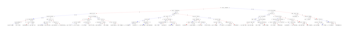

In [31]:
xgb.plot_tree(xcls.get_booster(), num_trees=1)

In [12]:
pd.Series(xmod.get_score(importance_type="gain")).sort_values(ascending=False).head(10)

ext_source_3                   38.397387
ext_source_2                   31.589963
cat_name_education_type        17.427612
flag_emp_phone                 15.987127
ext_source_1                   15.189964
cat_code_gender                14.551333
region_rating_client_w_city    13.706685
region_rating_client           12.376057
cat_name_contract_type         11.734054
days_birth                     11.193981
dtype: float64

In [13]:
import json


class PartialDependenceBase:
    def __init__(self, model, base_pred=0.0, missing=np.nan):
        self.p_dep = 0
        self.base_pred = base_pred
        self.tree_pred = 0.5
        self.n_leaves = 0
        self.missing = missing
        self.model = model

    def missing_value(self, value):
        return (value == self.missing) | (np.isnan(value) & np.isnan(self.missing))


class PartialDependenceSingle(PartialDependenceBase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def tree_pdp(self, node, feature, value, prop):
        if "leaf" in node:
            self.n_leaves += 1
            self.p_dep += prop * node["leaf"]
            return

        elif node["split"] == feature:
            if self.missing_value(value):
                nodeid = node["missing"]
            elif value < node["split_condition"]:
                nodeid = node["yes"]
            else:
                nodeid = node["no"]

            child = [chld for chld in node["children"] if chld["nodeid"] == nodeid][0]
            self.tree_pdp(child, feature, value, prop)
        else:
            l_s = node["children"][0]["cover"]
            r_s = node["children"][1]["cover"]
            t_s = l_s + r_s

            self.tree_pdp(node["children"][0], feature, value, prop * (l_s / t_s))
            self.tree_pdp(node["children"][1], feature, value, prop * (r_s / t_s))

    def calc_pdp(
        self, feature_name, feature_array, n_points=20
    ):  # min_max=(0.0, 513.0), n_pts=20,):
        res = np.empty(0)
        forest = [
            json.loads(d)
            for d in self.model.get_dump(dump_format="json", with_stats=True)
        ]
        if n_points is not None:
            min_, max_ = np.nanmin(feature_array), np.nanmax(feature_array)
            points = np.linspace(min_, max_, n_points)
        else:
            points = np.sort(np.unique(feature_array))

        for point in points:
            self.p_dep = self.base_pred
            self.n_leaves = 0
            for tree in forest:
                self.tree_pdp(tree, feature_name, point, 1)
            self.p_dep = self.p_dep  # / len(forest)
            res = np.append(res, self.p_dep)
        return np.column_stack((points, res))

In [14]:
pdp = PartialDependenceSingle(xmod)

Text(0.5, 1.0, 'cat_name_education_type PDP')

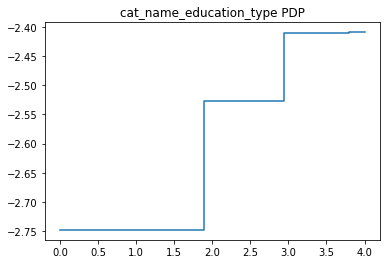

In [15]:
import matplotlib.pyplot as plt

pdr = pdp.calc_pdp("cat_name_education_type", df.loc[val, "cat_name_education_type"])
plt.step(pdr[:, 0], pdr[:, 1])
plt.title("cat_name_education_type PDP")

In [16]:
df_full.loc[df.index,][val].groupby(
    ["cat_name_education_type", "name_education_type"]
).agg({"target": ["count", "sum", "mean"]})

target                
                                                       count   sum      mean
cat_name_education_type name_education_type                                 
0                       Academic degree                   27     0  0.000000
1                       Higher education               12250   656  0.053551
2                       Incomplete higher               1703   158  0.092777
3                       Lower secondary                  639    63  0.098592
4                       Secondary / secondary special  35333  3064  0.086718

Text(0.5, 1.0, 'cat_code_gender PDP')

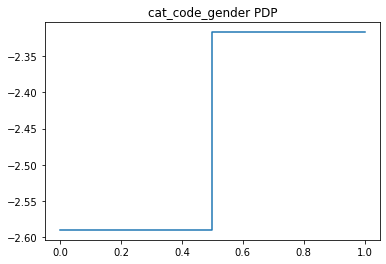

In [17]:
pdr = pdp.calc_pdp("cat_code_gender", df.loc[val, "cat_code_gender"], n_points=3)
plt.step(pdr[:, 0], pdr[:, 1])
plt.title("cat_code_gender PDP")

In [18]:
df_full.loc[df.index,][val].groupby(
    ["cat_code_gender", "code_gender"]
).agg({"target": ["count", "sum", "mean"]})

target                
                             count   sum      mean
cat_code_gender code_gender                       
0               F            32852  2285  0.069554
1               M            17100  1656  0.096842

Text(0.5, 1.0, 'days_birth PDP')

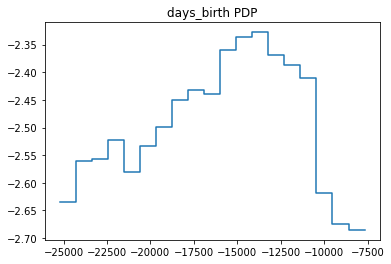

In [19]:
pdr = pdp.calc_pdp("days_birth", df.loc[val, "days_birth"])
plt.step(pdr[:, 0], pdr[:, 1])
plt.title("days_birth PDP")

<AxesSubplot:xlabel='days_birth', ylabel='Density'>

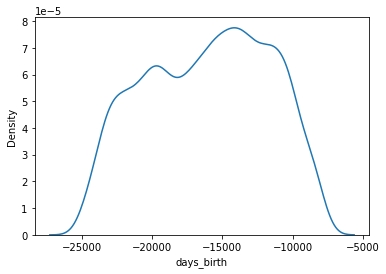

In [20]:
import seaborn as sns

sns.kdeplot(df.loc[val, "days_birth"].sample(10000))

In [21]:
pred = xmod.predict(xval)

In [22]:
np.corrcoef(pred, df.loc[val, "target"])

array([[1.        , 0.26114421],
       [0.26114421, 1.        ]])

In [23]:
{v: np.mean(pred[df.loc[val, "target"].eq(v)]) for v in [0, 1]}

{0: -2.9070327, 1: -1.9734153}

# Multivariate PDP
For the multivariate form, we will need to check for each feature, all other feature values.

In [45]:
import itertools


class PartialDependenceMulti(PartialDependenceBase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def tree_pdp(self, node, point_dict, prop):
        if "leaf" in node:
            self.n_leaves += 1
            self.p_dep += prop * node["leaf"]
            return

        elif node["split"] in point_dict:
            value = point_dict[node["split"]]
            if self.missing_value(value):
                nodeid = node["missing"]
            elif value < node["split_condition"]:
                nodeid = node["yes"]
            else:
                nodeid = node["no"]

            child = [chld for chld in node["children"] if chld["nodeid"] == nodeid][0]
            self.tree_pdp(child, point_dict, prop)
        else:
            l_s = node["children"][0]["cover"]
            r_s = node["children"][1]["cover"]
            t_s = l_s + r_s

            self.tree_pdp(node["children"][0], point_dict, prop * (l_s / t_s))
            self.tree_pdp(node["children"][1], point_dict, prop * (r_s / t_s))

    @staticmethod
    def get_eval_space(feature_list, feature_array_list, n_points):
        space_list = []
        for fa in feature_array_list:
            space_list.append(np.linspace(np.nanmin(fa), np.nanmax(fa), n_points))
        product = itertools.product(*space_list)
        return [
            {f: r for f, r in zip(feature_list, point_dicts)} for point_dicts in product
        ]

    def calc_pdp(
        self, feature_list, feature_array_list, n_points=20
    ):  # min_max=(0.0, 513.0), n_pts=20,):
        # res = np.empty(0)
        res = []
        forest = [
            json.loads(d)
            for d in self.model.get_dump(dump_format="json", with_stats=True)
        ]

        eval_points = self.get_eval_space(feature_list, feature_array_list, n_points)

        for point_dict in eval_points:
            self.p_dep = self.base_pred
            self.n_leaves = 0
            for tree in forest:
                self.tree_pdp(tree, point_dict, 1)
            # res = np.append(res, self.p_dep)
            point_dict["pd"] = self.p_dep
            res.append(point_dict)
        return res  # dict(points=eval_points, pd=res)

In [46]:
pdm = PartialDependenceMulti(xmod)

In [60]:
points = 50
mvals = pdm.calc_pdp(
    ["days_birth", "cat_name_education_type"],
    [df["days_birth"], df["cat_name_education_type"]],
    points,
)

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [62]:
mv_df = pd.DataFrame(mvals)

In [63]:
XX, YY = np.meshgrid(
    mv_df["days_birth"].unique(), mv_df["cat_name_education_type"].unique()
)
Z = mv_df["pd"].to_numpy().reshape(points, points)

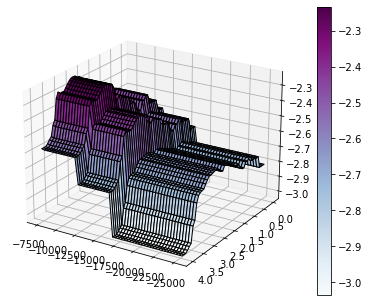

In [64]:
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.subplots_adjust(top=0.9)
plt.show()

In [58]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [59]:
from time import time

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer

print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        hidden_layer_sizes=(50, 50), learning_rate_init=0.01, early_stopping=True
    ),
)
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 3.891s
Test R2 score: 0.81


In [33]:
import sklearn

sklearn.__version__

'0.24.0'

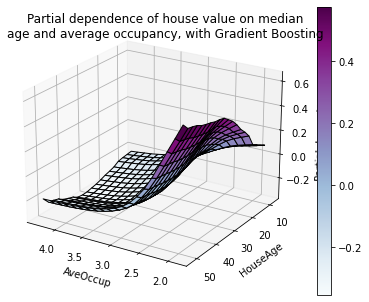

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.inspection import partial_dependence

fig = plt.figure()

features = ("AveOccup", "HouseAge")
pdp = partial_dependence(
    est, X_train, features=features, kind="average", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of house value on median\n"
    "age and average occupancy, with Gradient Boosting"
)
plt.subplots_adjust(top=0.9)
plt.show()

In [35]:
"cat_code_gender", "cat_name_education_type"

('cat_code_gender', 'cat_name_education_type')

In [36]:
def min_max(x):
    return np.nanmin(x), np.nanmax(x)

In [37]:
g = np.linspace(*min_max(df["cat_code_gender"]), 20)
e = np.linspace(*min_max(df["cat_name_education_type"]), 20)

In [38]:
t1 = zip([1, 2, 3], [4, 3, 2])